In [1]:
import pandas as pd 
import gc
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from keras import Sequential 
from keras.layers import Dense, InputLayer
from keras.utils.np_utils import to_categorical
import tensorflow as tf
tf.config.run_functions_eagerly(True)
import numpy as np

2021-07-21 20:07:12.232781: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
df = pd.read_csv('./sentences.csv', sep='\t', 
                            encoding='utf8', 
                            index_col=0,
                            names=['lang','text'])

In [3]:
LanguageList = ['eng','fra', 'spa','ita','deu']
ngramLength = 3
maxFeatures = 500
sentencePerLanguageForVocab = 1000
sentencePerLanguageForDataSet = 50000
validationSentences = 25000
testSentences = 25000

In [4]:
filtereddf = pd.DataFrame(columns=df.columns)
for l in LanguageList:
    filtereddf = pd.concat([filtereddf, 
                            df[df['lang'] == l].sample(
                                sentencePerLanguageForDataSet)])

filtereddf.describe()

,lang,text
count,250000,250000
unique,5,249999
top,eng,Un momento...
freq,50000,2


In [5]:
filtereddf = filtereddf.sample(frac=1)
validation_df = filtereddf[:validationSentences]
test_df = filtereddf[validationSentences:validationSentences + testSentences]
train_df = filtereddf[validationSentences + testSentences :]
train_df.describe()

,lang,text
count,200000,200000
unique,5,199999
top,deu,Un momento...
freq,40071,2


In [6]:
del df,filtereddf
gc.collect()

0

In [7]:
def get_feature_vectors(dataset):
    vectorizer = CountVectorizer(analyzer='char',ngram_range=(ngramLength,ngramLength),max_features=maxFeatures)
    vectorizer.fit_transform(dataset)
    trigrams = vectorizer.get_feature_names()
    return trigrams

In [8]:
vocab = set()
for l in LanguageList:
    currData = train_df[train_df['lang'] == l].sample(sentencePerLanguageForVocab)
    currFeatures = get_feature_vectors(currData['text'].to_list())
    vocab.update(currFeatures)
print(len(vocab))

1466


In [9]:
word_vectorizer = CountVectorizer(analyzer='char',ngram_range=(ngramLength,ngramLength), vocabulary=vocab)
feature_names = word_vectorizer.get_feature_names()
langEncoder = LabelEncoder()
langEncoder.fit(LanguageList)

LabelEncoder()

In [10]:
train_x = word_vectorizer.transform(train_df['text'].to_list())
min_value = train_x.min(axis=0).toarray()
min_df = pd.Series(min_value[0], index=feature_names)
max_value = train_x.max(axis=0).toarray()
max_df = pd.Series(max_value[0], index=feature_names)
del max_value,min_value,train_x

In [32]:
def data_generator(dataset, batch_size):
    noOfBatches = len(dataset)//batch_size
    batches = np.array_split(dataset,noOfBatches)
    i = 0
    while True:
        batch = batches[i]
        i += 1
        if i == noOfBatches:
            i = 0
        # getting x
        x = word_vectorizer.transform(batch['text'].to_list())
        xdf = pd.DataFrame(data=x.toarray(), columns=feature_names)
        xdf = (xdf - min_df)/(max_df - min_df)
        x_num = xdf.to_numpy()
    
        # getting y
        y = batch['lang'].to_list()
        y_enc = langEncoder.transform(y)
        y_num = to_categorical(y_enc, num_classes=len(LanguageList))
        yield x_num,y_num    

In [33]:
gen = iter(data_generator(train_df,3))
tempx, tempy = next(gen)

In [34]:
tempx.shape
tempy.shape

(4, 5)

In [35]:
batch_size = 5

In [82]:
train_generator = data_generator(train_df, batch_size)
val_generator = data_generator(validation_df, batch_size)
test_generator = data_generator(test_df, batch_size)

In [83]:
train_steps_per_epoch = len(train_df)//batch_size
val_steps_per_epoch = len(validation_df)//batch_size
test_steps_per_epoch = len(test_df)//batch_size

In [47]:
model = Sequential()
model.add(Dense(256,input_dim=len(vocab), activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(len(LanguageList), activation='softmax'))
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 256)               375552    
_________________________________________________________________
dense_13 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_14 (Dense)             (None, 5)                 645       
Total params: 409,093
Trainable params: 409,093
Non-trainable params: 0
_________________________________________________________________


In [50]:
model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])

In [51]:
model.fit(train_generator,
          steps_per_epoch=train_steps_per_epoch,
          validation_data=val_generator,
          validation_steps=val_steps_per_epoch,
          epochs=4)

Epoch 1/4
    6/40000 [..............................] - ETA: 15:06 - loss: 1.6053 - accuracy: 0.1517

/home/imdaredevil/.local/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:3703: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  warnings.warn(


40000/40000 [==============================] - 918s 23ms/step - loss: 0.0755 - accuracy: 0.9745 - val_loss: 0.0336 - val_accuracy: 0.9899
Epoch 2/4
40000/40000 [==============================] - 888s 22ms/step - loss: 0.0229 - accuracy: 0.9925 - val_loss: 0.0321 - val_accuracy: 0.9918
Epoch 3/4
40000/40000 [==============================] - 925s 23ms/step - loss: 0.0140 - accuracy: 0.9955 - val_loss: 0.0565 - val_accuracy: 0.9912
Epoch 4/4
40000/40000 [==============================] - 917s 23ms/step - loss: 0.0092 - accuracy: 0.9971 - val_loss: 0.0432 - val_accuracy: 0.9932


In [76]:
sentence = 'la casa de papel'

In [101]:
man_test_x = new_vectorizer.transform([sentence])
man_test_df = pd.DataFrame(data=man_test_x.toarray(), columns=new_vectorizer.get_feature_names())
man_test_df = (man_test_df - min_df)/(max_df - min_df)
man_test_num = man_test_df.to_numpy()
y = model.predict(man_test_num)
label = np.argmax(y)
prediction = newEncoder.inverse_transform([label])
prediction = prediction[0]
print(prediction)

spa


/home/imdaredevil/.local/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:3703: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  warnings.warn(


In [57]:
np.argmax(y)

1

In [58]:
y

array([[9.0647555e-14, 1.0000000e+00, 7.5185622e-17, 3.4363189e-13,
        8.5411566e-17]], dtype=float32)

In [60]:
langEncoder.inverse_transform([np.argmax(y)])

array(['eng'], dtype='<U3')

In [70]:
model.save('./models/basic-model.model')

2021-07-21 22:52:36.904989: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./models/basic-model.model/assets


In [71]:
from keras.models import load_model
my_model = load_model('./models/basic-model.model')

In [85]:
test_input, test_target = next(test_generator)
test_generator = data_generator(test_df, 100)
test_steps_per_epoch = len(test_df)//100
print(test_steps_per_epoch)
for i in range(test_steps_per_epoch):
    print(i)
    batch_x,batch_y = next(test_generator)
    test_input = np.concatenate((test_input,batch_x), axis=0)
    test_target = np.concatenate((test_target,batch_y), axis=0)

250
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249


In [86]:
test_predictions = my_model.predict(test_input)

/home/imdaredevil/.local/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:3703: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  warnings.warn(


In [90]:
def model_output_to_lang(outputs):
    labels = np.argmax(outputs,axis=1)
    return langEncoder.inverse_transform(labels)

In [92]:
test_target_lang=model_output_to_lang(test_target)
test_prediction_lang=model_output_to_lang(test_predictions)

In [93]:
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(test_target_lang,test_prediction_lang,labels=LanguageList)

In [94]:
cf

array([[5030,    6,    5,    3,    5],
       [   0, 5018,   20,   11,    1],
       [   5,   11, 4938,   37,    2],
       [   5,   15,   59, 4958,    1],
       [   7,    2,    7,    3, 4856]])

In [96]:
import matplotlib.pyplot as plot
import seaborn as sn

Matplotlib is building the font cache; this may take a moment.


<AxesSubplot:>

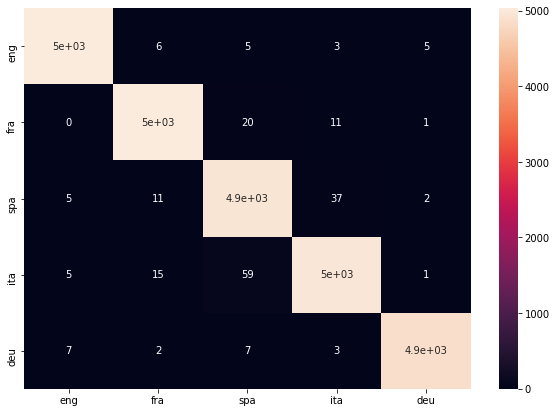

In [98]:
cf_df = pd.DataFrame(data=cf,columns=LanguageList,index=LanguageList)
plot.figure(figsize = (10,7))
sn.heatmap(cf_df, annot=True)

In [99]:
import pickle
pickle.dump(word_vectorizer,open('./models/basic-model-word-vectors.pkl','wb'))
pickle.dump(langEncoder,open('./models/basic-model-label-encoders.pkl','wb'))

In [100]:
new_vectorizer = pickle.load(open('./models/basic-model-word-vectors.pkl','rb'))
newEncoder = pickle.load(open('./models/basic-model-label-encoders.pkl','rb'))